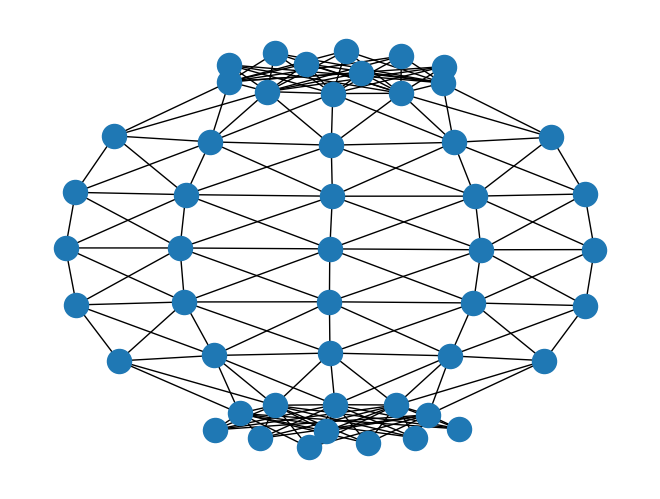

In [1]:

# conda install pytorch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0 -c pytorch -y & conda install pyg -c pyg -y & conda install -c anaconda networkx -y & conda install -c conda-forge matplotlib -y

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric.utils as utils
from utils import *
from model import UpdateRule



height = 7
width = 5
hidden_dim = 4
edge_dim = None
# edge_dim = 2

n_inputs = 3
n_outputs = 3


update_rule = UpdateRule(
    n_inputs, 
    n_outputs,
    hidden_dim,
    edge_dim,
    4
)
update_rule.build_graph(
    height,
    width
)


# cuda_device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
cuda_device = torch.device("cpu")

update_rule = update_rule.to(cuda_device)

# edge_attr = torch.concat(
#     (
#         torch.tensor([[1,0]]*(update_rule.graph.edge_index[0].shape[0]//2)), 
#         torch.tensor([[0,1]]*(update_rule.graph.edge_index[0].shape[0]//2))
#     ), 
# 0).float()
edge_attr = None


update_rule.draw()



In [2]:
from training import *
from datasets import *


meta_set = MetaDataset()
optimizer = torch.optim.Adam(update_rule.parameters(), lr=0.005)

train_on_meta_set(
    update_rule, optimizer, meta_set, {
        "n_steps": 1,
        "batch_size" : 5,
        "n_epochs" : 1000,
    }, edge_attr = edge_attr
)


RuntimeError: The expanded size of the tensor (7) must match the existing size (3) at non-singleton dimension 0.  Target sizes: [7, 2].  Tensor sizes: [3, 2]

In [ ]:
import gym
import pygad
import pygad.torchga
import torch
import numpy as np

gen_start = True
def fitness_func(solution, sol_idx):
    global gen_start,keras_ga, update_rule, observation_space_size, env

    model_weights_dict = pygad.torchga.model_weights_as_dict(model=update_rule, weights_vector=solution)

    update_rule.load_state_dict(model_weights_dict)
    update_rule.reset() 
    x = update_rule.initial_state()
    
    # play game
    observation = env.reset()
    sum_reward = 0
    done = False
    c = 0
    while (not done) and c<1000:
        state = torch.tensor(np.reshape(observation, [1, observation_space_size])).float()#.to(cuda_device)
        
        x = update_rule.act(x, state, n_step=2)
        q_values = update_rule.get_output(x, softmax=False)
        # action = np.argmax(q_values.detach().cpu().numpy())
        action = q_values.detach().cpu().numpy()
        if gen_start and e % 5 == 0:
            env.render()
            
            
            
        # q_values = update_rule(state)
        # action = np.argmax(q_values[0].detach().cpu().numpy())
        observation_next, reward, done, info = env.step(action)
        observation = observation_next
        sum_reward += reward
        c += 1
    gen_start = False
    return sum_reward


e = 0
def callback_generation(ga_instance):
    global e, gen_start
    e += 1
    gen_start = True
    if not (e % 5 == 0):
        return 
    
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))


env = gym.make("BipedalWalker-v3")

observation_space_size = env.observation_space.shape[0]
# action_space_size = env.action_space.n

# print("observation_space_size =", observation_space_size)
# print("action_space_size =", action_space_size)


# update_rule = torch.nn.Sequential(
#      torch.nn.Linear(in_features=4, out_features=4),
#         torch.nn.ReLU(),
#         torch.nn.Linear(in_features=4, out_features=4),
#         torch.nn.ReLU(),
#         torch.nn.Linear(in_features=4, out_features=2),
# )

torch_ga = pygad.torchga.TorchGA(model=update_rule,
                           num_solutions=10)

ga_instance = pygad.GA(num_generations=10000,
                       num_parents_mating=5,
                       initial_population=torch_ga.population_weights,
                       fitness_func=fitness_func,
                       parent_selection_type="sss",
                       crossover_type="single_point",
                       mutation_type="random",
                       mutation_percent_genes=10,
                       keep_parents=-1,
                       random_mutation_min_val = -0.1,
                       random_mutation_max_val = 0.1,
                       on_generation=callback_generation)

ga_instance.run()


RuntimeError: The expanded size of the tensor (7) must match the existing size (24) at non-singleton dimension 0.  Target sizes: [7, 2].  Tensor sizes: [24, 2]

In [ ]:
update_rule.graph.edge_index

In [ ]:
from torch_geometric.utils import add_self_loops, remove_self_loops, softmax
remove_self_loops(update_rule.graph.edge_index, None)

In [ ]:
update_rule.edge_index

In [ ]:

print( MetaDataset().get_set(0).is_undirected())

In [ ]:
TimeDataset4().is_directed()

In [ ]:
for x in TranslateDataset(0):
    print(x)

In [ ]:
len(meta_set.get_set(0))